# Evolution of the 3 pointer since the year 2000

## Questions

    1. How have the amount of 3 pointers taken by teams changed throughout the years?
    2. How has offensive efficiency changed overtime? Does it correspond to the 3 pointer trend?
    3. Do teams that take more 3 pointers have more efficient offenses?

In [265]:
#Import packages
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import matplotlib.style as style
pd.set_option('display.max_columns', 50)
%matplotlib inline
style.use('fivethirtyeight')

In [107]:
#import datasets
plyr_logs = pd.read_csv('player_logs_clean.csv')
team_logs = pd.read_csv('team_logs_clean.csv')

In [211]:
def possessions(data):
    """Approximate possessions per game"""
    return data.fga - data.oreb + data.tov+.4*data.fta

def off_eff(data):
    return 100 * data.pts / data.possessions

def season_stats(data,season):
    """Return the data relevant to a particular season"""
    return data.loc[data.season == season]

In [212]:
#We will want to analyze the offensive efficiency based on points per possession, so lets add those collumns to the dataset
team_logs['possessions'] = possessions(team_logs)
team_logs['off_eff'] = off_eff(team_logs)
team_logs.head(5)

,game_date,year,month,day,season_id,season,team_id,team,team_name,opp,game_id,matchup,wl,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,video_available,fscore,possessions,off_eff
0,2000-10-31,2000,10,31,22000,2000,1610612762,UTA,Utah Jazz,LAC,20000010,UTA vs. LAC,1.0,240,43,85,0.506,5,10,0.500,16,31,0.516,11,22,33,33,11,4,12,30,107,13,0,228.75,98.4,108.739837
1,2000-10-31,2000,10,31,22000,2000,1610612747,LAL,Los Angeles Lakers,POR,20000012,LAL @ POR,1.0,240,36,63,0.571,5,11,0.455,19,30,0.633,8,31,39,28,5,8,20,18,96,10,0,209.75,87.0,110.344828
2,2000-10-31,2000,10,31,22000,2000,1610612763,MEM,Vancouver Grizzlies,SEA,20000013,VAN vs. SEA,1.0,240,39,90,0.433,4,14,0.286,12,26,0.462,14,37,51,28,12,6,11,21,94,6,0,236.75,97.4,96.509240
3,2000-10-31,2000,10,31,22000,2000,1610612757,POR,Portland Trail Blazers,LAL,20000012,POR vs. LAL,0.0,240,34,85,0.400,4,11,0.364,14,16,0.875,13,19,32,18,13,1,10,28,86,-10,0,182.50,88.4,97.285068
4,2000-10-31,2000,10,31,22000,2000,1610612756,PHX,Phoenix Suns,GSW,20000011,PHX @ GSW,0.0,240,36,91,0.396,6,21,0.286,16,20,0.800,11,33,44,25,12,3,16,28,94,-2,0,216.00,104.0,90.384615


### Analyzing Trends

If you're a basketball fan, you might be familiar with the fact that teams are shooting a lot more 3 pointers now than they did in past seasons. But how pronounced is the difference? Let's dig into the data by looking at the distribution of the number of 3 pointers attempted in the 2000-01 season compared to the most recent 2017-18 season. 

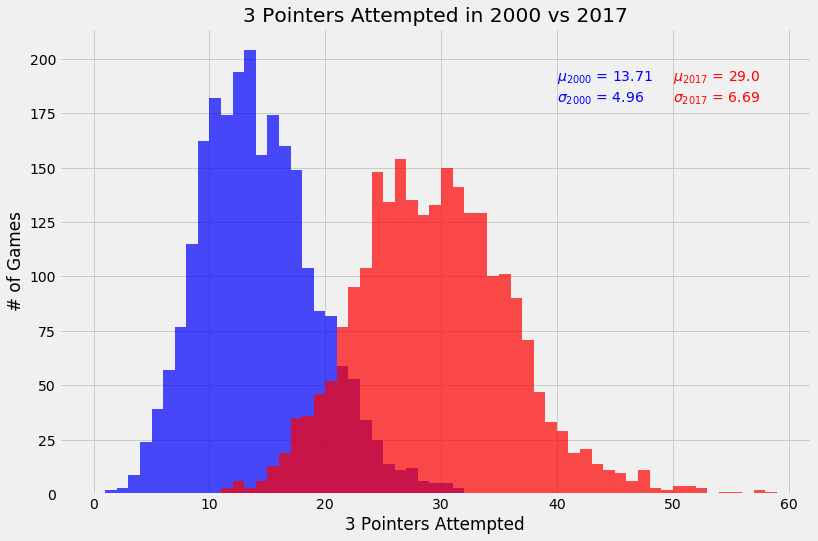

In [240]:
tm_logs_00 = season_stats(team_logs,2000)
tm_logs_17 = season_stats(team_logs,2017)

mean_fg3a_00 = tm_logs_00.fg3a.mean()
mean_fg3a_17 = tm_logs_17.fg3a.mean()

std_fg3a_00 = tm_logs_00.fg3a.std()
std_fg3a_17 = tm_logs_17.fg3a.std()

plt.clf()
plt.figure(figsize=(12,8))
plt.hist(tm_logs_00.fg3a, bins=range(0,60), color = 'blue', alpha = .7)
plt.hist(tm_logs_17.fg3a, bins=range(0,60), color = 'red', alpha = .7)
plt.text(x=40, y = 190, s =r'$\mu_{2000}$ = '+str(round(mean_fg3a_00,2)), color = 'blue')
plt.text(x=40, y = 180, s =r'$\sigma_{2000}$ = '+str(round(std_fg3a_00,2)), color = 'blue')
plt.text(x=50, y = 190, s =r'$\mu_{2017}$ = '+str(round(mean_fg3a_17,2)), color = 'red')
plt.text(x=50, y = 180, s =r'$\sigma_{2017}$ = '+str(round(std_fg3a_17,2)), color = 'red')
plt.xlabel('3 Pointers Attempted')
plt.ylabel('# of Games')
plt.title('3 Pointers Attempted in 2000 vs 2017')
plt.show()


#### Significant difference

The distributions seen above do a great job of highlighting the drastic change in the amount of 3 pointers taken at the start of the century and now. The average amount of 3 pointers in a game has more than doubled from 13.71 attempts to to 29 attempts a game. We can also see that there is a larger spread now on a game to game basis.  The most interesting thing is the maximum number of threes attempted in a game in 2000 seems to be around 32-33 attempts, while that is closer the the average in todays game. Lets investigate this a bit further.

#### Create Tables for Team Averages and League Averages

In [220]:
stat_cols = ['min', 'fgm', 'fga','fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 
             'ftm', 'fta', 'ft_pct', 'oreb','dreb', 'reb', 'ast', 'stl', 
             'blk', 'tov', 'pf', 'pts', 'plus_minus', 'fscore', 'possessions','off_eff']
team_avgs = team_logs.groupby(['season','team'])[stat_cols].mean().reset_index()
league_avgs = team_avgs.groupby('season')[stat_cols].mean().reset_index()

team_avgs.head()

,season,team,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,possessions,off_eff
0,2000,ATL,240.609756,35.073171,81.317073,0.431305,4.060976,11.378049,0.359317,16.756098,22.085366,0.765671,12.536585,30.365854,42.902439,19.012195,7.731707,4.719512,16.682927,22.719512,90.963415,-5.207317,196.164634,94.297561,96.505827
1,2000,BKN,240.609756,33.914634,79.878049,0.424195,4.402439,13.219512,0.325049,19.865854,26.170732,0.761171,11.085366,28.500000,39.585366,19.548780,7.914634,4.963415,14.731707,24.170732,92.097561,-5.048780,195.993902,93.992683,97.966390
2,2000,BOS,241.829268,33.817073,79.085366,0.428549,7.219512,19.914634,0.356805,19.768293,26.707317,0.736402,10.939024,28.865854,39.804878,20.829268,9.378049,4.097561,15.670732,23.804878,94.621951,-2.134146,202.847561,94.500000,100.232010
3,2000,CHA,242.439024,34.146341,79.280488,0.432915,4.146341,12.000000,0.340244,19.500000,26.170732,0.743256,12.597561,31.804878,44.402439,23.170732,8.109756,5.548780,14.426829,21.378049,91.939024,2.097561,208.875000,91.578049,100.425228
4,2000,CHI,242.134146,33.182927,78.182927,0.425561,4.012195,11.585366,0.347720,17.195122,23.280488,0.736854,11.292683,27.560976,38.853659,22.073171,8.231707,4.621951,15.756098,23.195122,87.573171,-9.097561,193.585366,91.958537,95.283037


In [235]:
#Table of minimum and maximum number of 3s averaged by a team each season
threes_min_max = team_avgs.groupby(['season']).agg(['min','max']).fg3a.reset_index()
threes_min_max

,season,min,max
0,2000,8.036585,19.914634
1,2001,8.719512,23.731707
2,2002,7.817073,26.280488
3,2003,9.585366,23.609756
4,2004,8.158537,24.707317
5,2005,9.707317,25.573171
6,2006,10.036585,23.987805
7,2007,11.451220,26.646341
8,2008,11.573171,27.853659
9,2009,12.439024,27.329268


#### Visualize the table
In the table above we can see that the minimum amount of 3 pointers averaged in 2017-18 and even in 2016-17, is greater than the league leader in average number of 3's attempted back in the 2000-01 season. Lets visualize this minimum and maximum values.

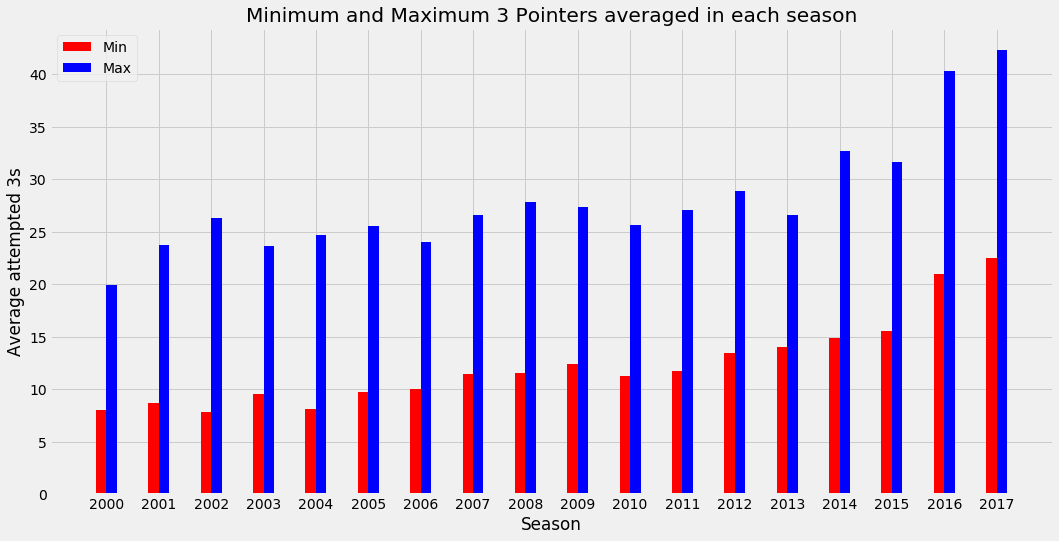

In [246]:
min3s = threes_min_max['min']
max3s = threes_min_max['max']


fig, ax = plt.subplots(figsize = (16,8))

ind = np.arange(2000,2018)    # the x locations for the groups
width = 0.2         # the width of the bars
p1 = ax.bar(ind, min3s, width, color='r')

p2 = ax.bar(ind + width, max3s, width,
            color='b')

ax.set_title('Minimum and Maximum 3 Pointers averaged in each season')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([x for x in threes_min_max.season])
ax.legend((p1[0], p2[0]), ('Min', 'Max'))

plt.xlabel('Season')
plt.ylabel('Average attempted 3s')

ax.autoscale_view()

plt.show()

#### Plot the trand of increasing threes over time

We can clearly see from the plots above that there is a shift in the number of 3 pointers teken each year. Let's put this onto a chart the plots the average number of 3's attempted in the league over time to get a clear idea of the trend.


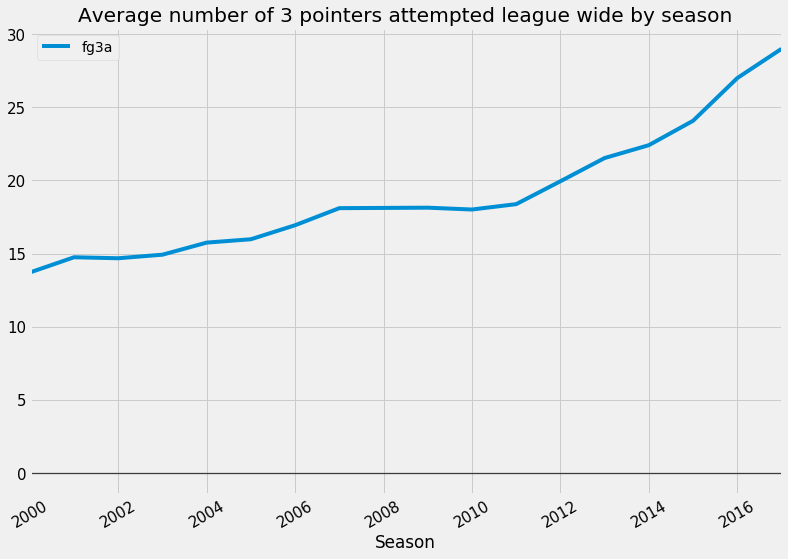

In [249]:
fg3 = league_avgs.plot(x = 'season', y = 'fg3a', figsize = (12,8))
fg3.tick_params(axis = 'both', which = 'major', labelsize = 15)
fg3.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.xticks(x = 'season', rotation=30)
plt.xlabel('Season')
plt.title('Average number of 3 pointers attempted league wide by season')
plt.show()


We can clearly see that since the turn of the century, the amount of three pointers attempted by the league as a whole has basically doubled. It seems as thought things stayed pretty constant for a few years in the middle between 2007 and 2011, but the last 5 years there has been a major jump in 3 pointers taken.

### The relationship between 3 pointers attempted and offensive efficiency

Since we know that teams are attempting more 3 pointers, lets see if that has any effect on offensive efficiency of teams.

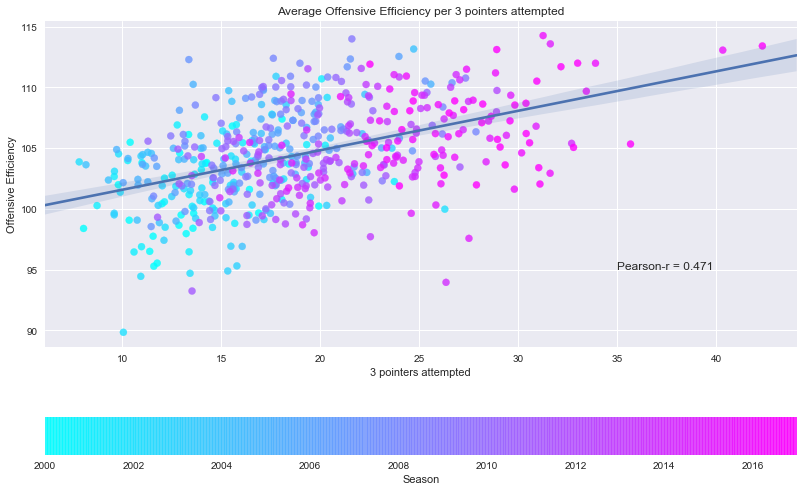

In [282]:
#calculate the pearson correlation between 3 pointers attempted and offensive efficiency
corr = round(stats.pearsonr(team_avgs.fg3a, team_avgs.off_eff)[0],3)

sns.set()
plt.figure(figsize=(12,8))
plt.scatter(team_avgs.fg3a, team_avgs.off_eff, marker = '.',c = team_avgs.season, s = 200, alpha = .8, cmap = 'cool')
sns.regplot('fg3a', 'off_eff', team_avgs, scatter = False)
plt.text(x=35, y=95, s = 'Pearson-r = '+str(corr))
plt.xlabel('3 pointers attempted')
plt.ylabel('Offensive Efficiency')
plt.title('Average Offensive Efficiency per 3 pointers attempted')
plt.colorbar(orientation='horizontal').set_label('Season')
plt.show()


## Conclusion

The final plot shows that generally, the more 3 pointers a team attempts per game, the more efficient their offense is. The positive correlation between these two variables, combined with the knowledge that 3 pointers have become more prevelant year after year, tells us that the average offense of the present is a lot more efficient that the past. This can also be visualized by the gradient in the chart, with the bluer shades showing represents the early 2000's and the purplish-pink dots representing more modern day basketball. 

Where can we go from here? There a lot of great questions that can still be analyzed from these observations. Is there a limit to how many 3 pointers a team should take before the offensive efficiency starts to come back down? How have defenses faired against these higher octane offenses? Have players who can't shoot a high 3 point percentage become less valuable? The factors are endless, and the stories to be told are too many to fit onto one notebook.